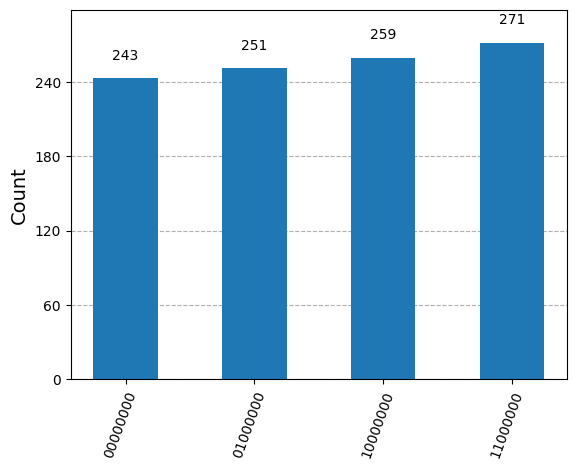

In [13]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit import transpile
import numpy as np

circuit = QuantumCircuit(12, 8)

def c_amodN(a, N, power):
    """Controlled multiplication by a mod N"""
    if a == 1:
        raise ValueError("'a' must be greater than 1")
    elif N % a == 0:
        raise ValueError("'a' must not be a factor of 'N'")
    elif np.gcd(a, N) > 1:
        raise ValueError("'a' and 'N' must not share a factor")
    gate_size = len(np.binary_repr(N))
    gate_max = 2 ** gate_size  - 1
    
    a_bi = np.binary_repr(a)
    a_bi_fixed = np.binary_repr(a, width=gate_size)
    a_bi_floor = 2**len(a_bi) if 2**len(a_bi) == a else 2**(len(a_bi) - 1)
    
    # a + b = "1" * gate_size
    b = gate_max - a
    b_bi = np.binary_repr(b)
    b_bi_fixed = np.binary_repr(b, width=gate_size)
    b_bi_floor = 2**len(b_bi) if 2**len(b_bi) == b else 2**(len(b_bi) - 1)
    
    # plan for swaps
    base_reverse = False if a - a_bi_floor < b - b_bi_floor else True
    swap_base_number = a if not base_reverse else b 
    swap_bi = a_bi if not base_reverse else b_bi
    swap_bi_floor = a_bi_floor if not base_reverse else b_bi_floor
    swap_base = "a"  if not base_reverse else "b"
    
    swap_dist = len(swap_bi) - 1
    swap_order = "backward"
    if swap_bi_floor > ((gate_max + 1) / 4):
        swap_dist = gate_size - swap_dist
        swap_order = "forward"
    n_swaps = gate_size - swap_dist
        
    U = QuantumCircuit(gate_size)
    
    for _iteration in range(power):
        init_state = np.zeros(gate_size, dtype="int")
        init_state[0] = 1
        swaped_state_number = 1
        for i in range(n_swaps):
            if swap_order == "backward":
                x = gate_size - i - swap_dist - 1
                y = gate_size - i - 1
            elif swap_order == "forward":
                x = i
                y = i + swap_dist
            init_state[[x, y]] = init_state[[y, x]]
            swaped_state_number = int(''.join(map(str, np.flip(init_state))), 2)
            if swaped_state_number > swap_base_number:
                init_state[[x, y]] = init_state[[y, x]]
                swaped_state_number = int(''.join(map(str, np.flip(init_state))), 2)
                break
            else:
                U.swap(x, y)
        if swaped_state_number == a:
            pass
        elif gate_max - swaped_state_number == a:
            for q in range(gate_size):
                U.x(q)
        else:
            for j in range(gate_size):
                if init_state[j] != int(a_bi_fixed[gate_size - j - 1]):
                    U.x(j)
    U = U.to_gate()
    U.name = f"{a}^{power} mod {N}" 
    c_U = U.control()
    return c_U

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc


SHORS_COUNT_QUBITS = [0, 1, 2, 3, 4, 5, 6, 7]
SHORS_ORACLE_QUBITS = [8, 9, 10, 11]
SHORS_MOD = 15
SHORS_FACTOR = 2


# SHORS_ORACLE_SIZE: the size of QPE gate
# SHORS_MOD: the divider
# SHORS_FACTOR: the base number
# SHORS_COUNT: # of the counting qubits
SHORS_COUNT = len(SHORS_COUNT_QUBITS)
SHORS_ORACLE_SIZE = len(SHORS_ORACLE_QUBITS)

# Initialize counting qubits
# in state |+>
for q in range(SHORS_COUNT):
    circuit.h(q)

# And auxiliary register in state |1>
circuit.x(SHORS_ORACLE_QUBITS[0])

# Do controlled-U operations
for q in SHORS_COUNT_QUBITS:
    circuit.append(c_amodN(SHORS_FACTOR, SHORS_MOD, 2**q),
            [SHORS_COUNT_QUBITS[q]] + SHORS_ORACLE_QUBITS)

# Do inverse-QFT
circuit.append(qft_dagger(SHORS_COUNT), range(SHORS_COUNT))

# Don't forget to measure circuit if you didnt! (uncomment this)
# circuit.measure(range(SHORS_COUNT), range(SHORS_COUNT))


# Measure
circuit.measure([1, 0, 2, 4, 3, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7])

aer_sim = AerSimulator()

transpiled = transpile(circuit, aer_sim)
job = aer_sim.run(transpiled)

counts = job.result().get_counts()
plot_histogram(counts)

